# Nutria
In this Notebook we'll consider the population growth of the Nutria species. The data has been taken from .. . We'll begin importing the data and visualizing it.

<AxesSubplot:title={'center':'Nutria population'}>

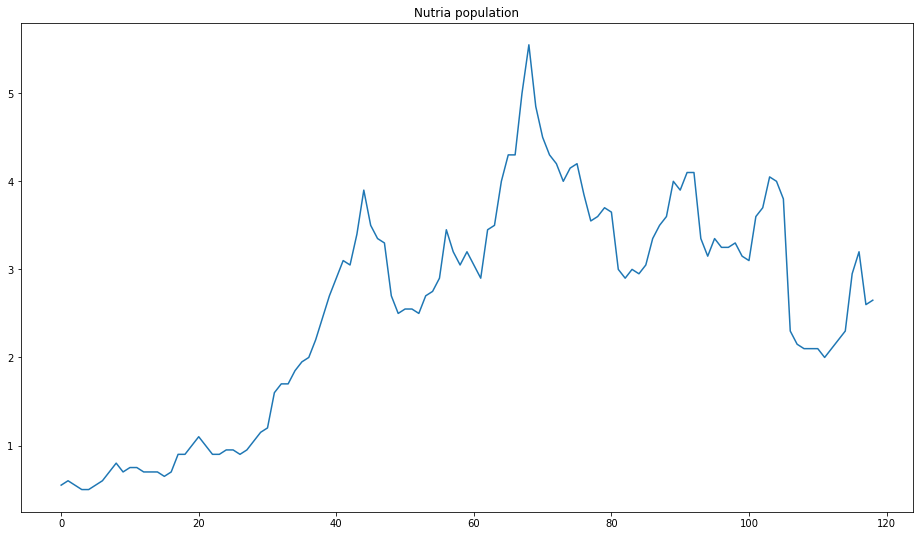

In [1]:
import pandas as pd

data = pd.read_csv("nutria.txt", sep="\t").iloc[:, 0].rename("nutria")

data.plot(figsize=(16, 9), title="Nutria population")

We'll use the same model as in [stoch-proc](https://github.com/tingiskhan/stoch-proc/blob/master/examples/nutria.ipynb), and thus get

In [2]:
from pyfilter import inference as inf, filters as filts, __version__
from stochproc import timeseries as ts, __version__ as sp_version, distributions as dists
from pyro.distributions import LogNormal, Exponential, Gamma, InverseGamma, Normal
from torch.distributions import Distribution
from math import log


def f(x, a, b, c, sigma_e):
    exped = x.values.exp()
    return x.values + a + b * exped + c * exped ** 2, sigma_e.sqrt()


print(f"stoch-proc: {sp_version}")
print(f"pyfilter: {__version__}")


def build_obs(x, a, s):
    return Normal(loc=a * x.values, scale=s.sqrt())


def build_model(context: inf.ParameterContext):
    a = context.named_parameter("a", inf.Prior(Normal, loc=0.0, scale=1.0))
    b = context.named_parameter("b", inf.Prior(Normal, loc=0.0, scale=1.0))
    c = context.named_parameter("c", inf.Prior(Normal, loc=0.0, scale=1.0))
    
    alpha = data.shape[0] / 2.0
    beta = 2 * (alpha - 1.0) / 10.0     
    sigma_e = context.named_parameter("sigma_e", inf.Prior(InverseGamma, concentration=alpha, rate=beta))
    
    initial_dist = dists.DistributionModule(Normal, loc=0.0, scale=1.0)    
    inc_dist = dists.DistributionModule(Normal, loc=0.0, scale=1.0)
    
    hidden = ts.AffineProcess(f, (a, b, c, sigma_e), initial_dist=initial_dist, increment_dist=inc_dist)
        
    sigma_n = context.named_parameter("sigma_n", inf.Prior(InverseGamma, concentration=alpha, rate=beta))
    
    return ts.StateSpaceModel(hidden, build_obs, (1.0, sigma_n)).cuda()


stoch-proc: 0.0.9
pyfilter: 0.24.0


Next, we'll use SMC2 together with APF to perform inference on the logged dataset.

In [3]:
from pyfilter.inference.sequential import SMC2
from pyfilter.filters.particle import APF, proposals as p
import torch


logged_data = torch.from_numpy(data.values).float().log()


results = list()
for i in range(2):
    with inf.make_context() as context:
        filt = APF(build_model, 250, proposal=p.LinearGaussianObservations(0))
        alg = SMC2(filt, 1_000, num_steps=5)

        state = alg.fit(logged_data)

        results.append((context, state))

SMC2:   1%|▋                                                                           | 1/119 [00:00<01:54,  1.03it/s]H:\anaconda3\lib\site-packages\torch\distributions\gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is C:\Users\victo\AppData\Local\Temp/torch/kernels. This warning will appear only once per process. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cuda\jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))
SMC2: 100%|██████████████████████████████████████████████████████████████████████████| 119/119 [00:06<00:00, 19.20it/s]


Next, let's visualize the filtered means of the state.

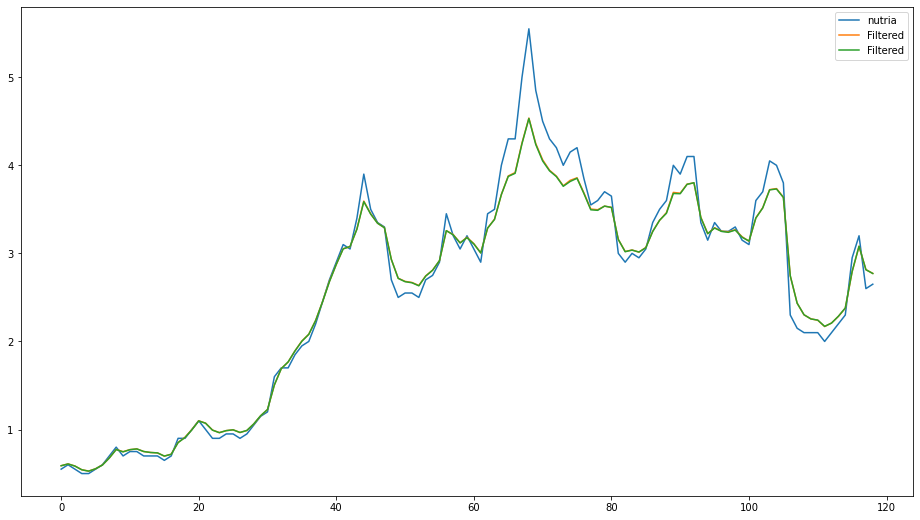

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

data.plot(ax=ax)

for _, state in results:
    means = state.filter_state.filter_means @ state.normalized_weights()
    ax.plot(means[1:].exp().cpu().numpy(), label="Filtered")

ax.legend()

Next, let's visualize the posterior distributions of the parameters. Here we'll use non-weighted parameter posteriors (which is wrong), since `arviz` doesn't support weighted posteriors out of the box.

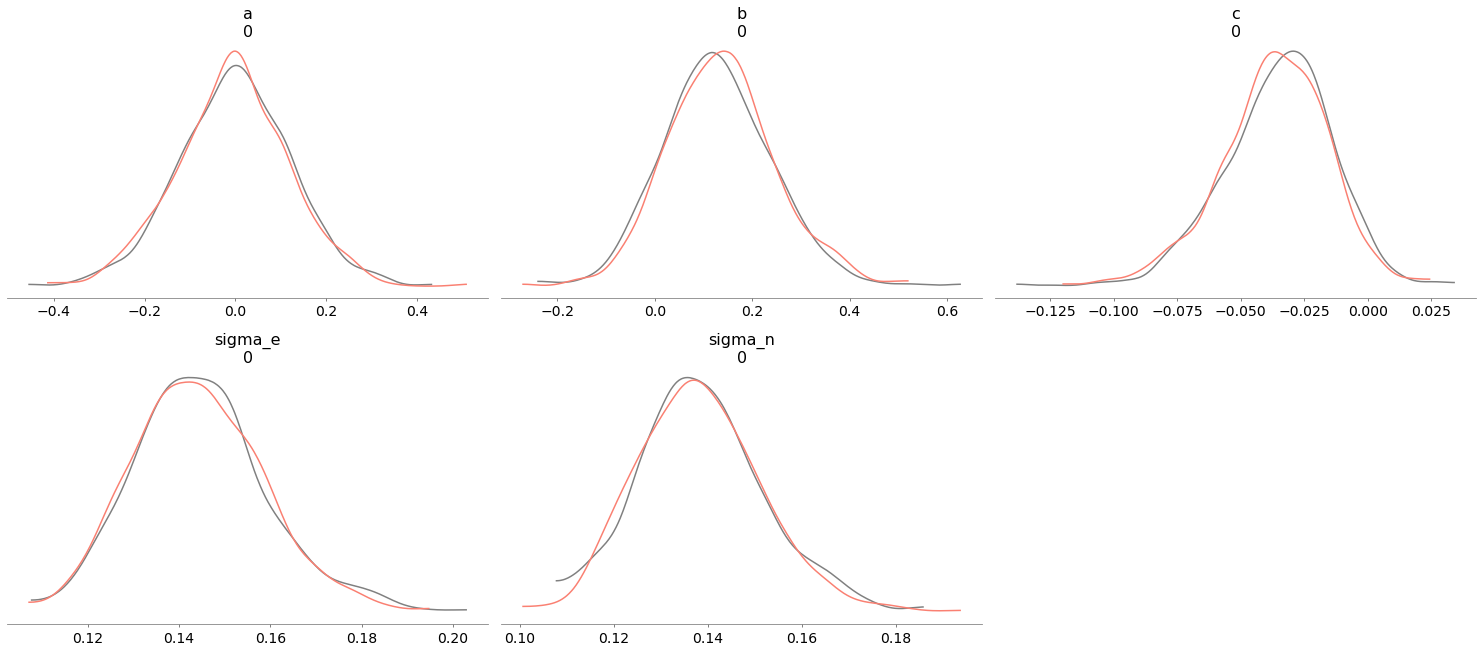

In [5]:
import pandas as pd
import arviz

colors = ["gray", "salmon"]
ax = None

for j, (context, state) in enumerate(results):
    w = state.normalized_weights()
    trace = arviz.convert_to_inference_data({n: v.unsqueeze(0).cpu().numpy() for n, v in context.parameters.items()})
    ax = arviz.plot_posterior(trace, ax=ax, color=colors[j], point_estimate=None, hdi_prob="hide")

plt.tight_layout()

Comparing the above plots with the ones obtained in [stoch-proc](https://github.com/tingiskhan/stoch-proc/blob/master/examples/nutria.ipynb), we clearly see that we have roughly the same posteriors obtained in a fraction of the time.